# Decision Trees

Moving on from naive bayes classifier, we'll use decision trees to try and classify our data.

In [1]:
# import libraries
from warnings import filterwarnings
filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score
from sklearn.metrics import plot_roc_curve
from sklearn.tree import DecisionTreeClassifier

from imblearn.over_sampling import SMOTENC

from src.seed import SEED
from src.helper import confmat, praf1

%matplotlib inline
sns.set(font_scale=1.2)

In [2]:
# load training data, split it
train = pd.read_csv("../data/processed/train.csv")

X = train.iloc[:, :-1]
y = train.iloc[:, -1]

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=SEED, stratify=y)

## Vanilla Decision Tree

In [3]:
# create basic model, fit and predict
dt = DecisionTreeClassifier(random_state=SEED)
dt.fit(X_train, y_train)

train_pred = dt.predict(X_train)
test_pred = dt.predict(X_test)

In [4]:
# output results
a = praf1(y_train, train_pred, "Training")
b = praf1(y_test, test_pred, "Testing")
pd.concat([a, b])

,precision,recall,accuracy,f1
Training,1.000000,1.000000,1.000,1.000000
Testing,0.641304,0.648352,0.896,0.644809


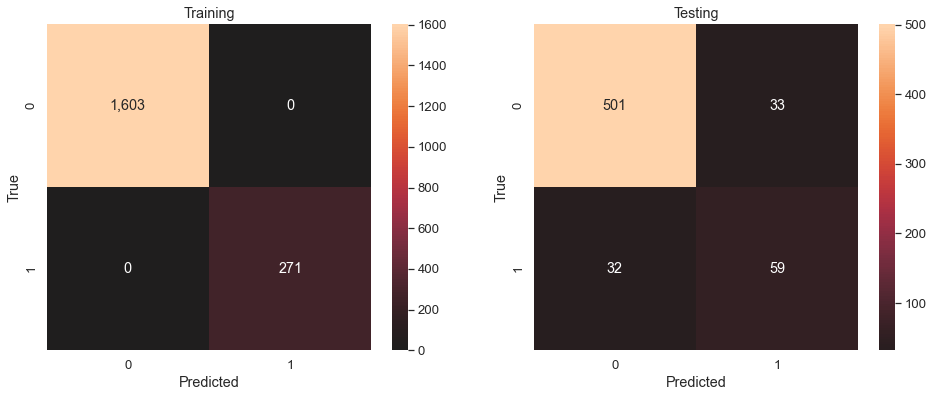

In [5]:
# output confusion matrix
confmat([y_train, y_test], [train_pred, test_pred], ["Training", "Testing"])

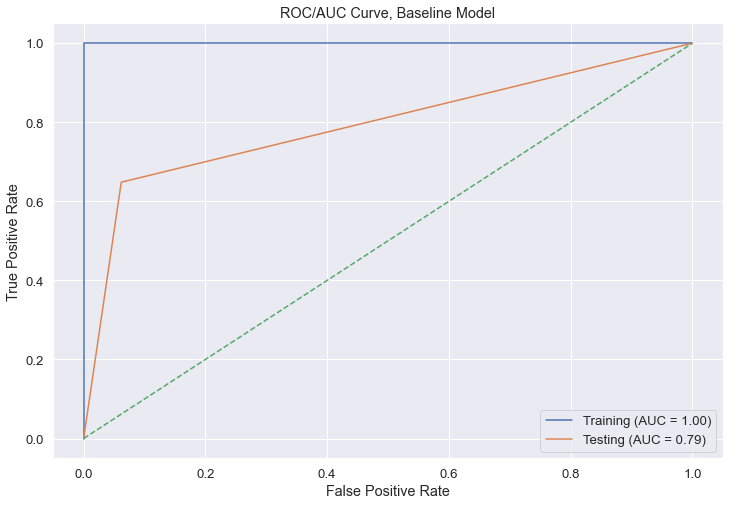

In [6]:
# output roc/auc
fig, ax = plt.subplots(figsize=(12, 8))

plot_roc_curve(dt, X_train, y_train, name="Training", ax=ax)
plot_roc_curve(dt, X_test, y_test, name="Testing", ax=ax)
line = np.linspace(0, 1)

plt.plot(line, line, "--")

plt.title("ROC/AUC Curve, Baseline Model")
plt.show()

Our baseline model has over fit to our training data as can be seen by the perfect training scores, however the testing results shows some promise with precision and recall practically equal, an accuracy close to 90%, and an f1_score of .65.

It may be that a decision tree would best work for our data, and tuning it to not overfit as much will allow us to get a model that scores well with training and testing data. We'll also want to look into compensating for our class imbalance.

## Class Imbalance Compensation

In [7]:
# create new training dataset
sm = SMOTENC(np.arange(19, 69), random_state=SEED, n_jobs=-1)
X_train, y_train = sm.fit_resample(X_train, y_train)

In [8]:
# create basic model, fit and predict
dt1 = DecisionTreeClassifier(random_state=SEED)
dt1.fit(X_train, y_train)

train_pred = dt1.predict(X_train)
test_pred = dt1.predict(X_test)

In [9]:
# output results
a = praf1(y_train, train_pred, "Training")
b = praf1(y_test, test_pred, "Testing")
pd.concat([a, b])

,precision,recall,accuracy,f1
Training,1.000000,1.000000,1.0000,1.000000
Testing,0.533333,0.703297,0.8672,0.606635


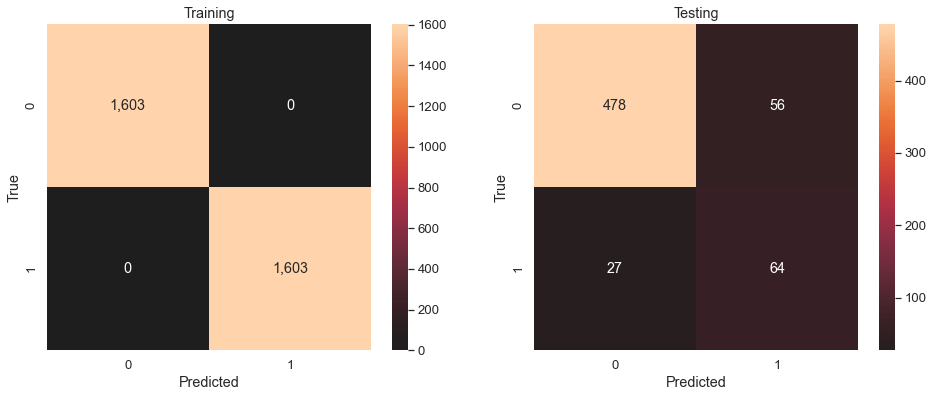

In [10]:
# output confusion matrix
confmat([y_train, y_test], [train_pred, test_pred], ["Training", "Testing"])

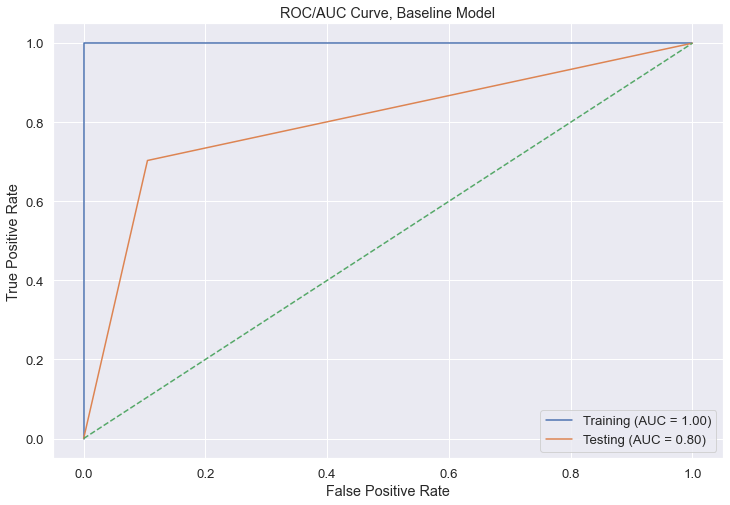

In [11]:
# output roc/auc
fig, ax = plt.subplots(figsize=(12, 8))

plot_roc_curve(dt1, X_train, y_train, name="Training", ax=ax)
plot_roc_curve(dt1, X_test, y_test, name="Testing", ax=ax)
line = np.linspace(0, 1)

plt.plot(line, line, "--")

plt.title("ROC/AUC Curve, Baseline Model")
plt.show()

Our model accounting for class imbalance has worse performance than our vanilla model, all scores have dropped in testing other than recall which has shown an improvement. There should be a discussion of whether or not this is actually a bad thing, but in our case, recall > precision. As reducing customer churn is the main goal, this model would correctly identify more individuals who would have left.

## Hyper Parameter Tuning

With decision trees we have to prune their growth, and make sure they don't over fit the training data.
We'll work on doing this by using Randomized Search to find an optimal parameter set.

In [12]:
# create parameter grid, and fit grid search
param_grid = {
    "criterion": ["gini", "entropy"],
    "max_depth": np.arange(1, 16),
    "min_samples_leaf": np.arange(1, 500, 2)
}

r_search = RandomizedSearchCV(DecisionTreeClassifier(random_state=SEED), param_grid, n_iter=1e3, scoring="f1", n_jobs=-1, random_state=SEED)
r_search.fit(X_train, y_train)

print(r_search.best_params_)

print("Mean Test Score:", r_search.cv_results_["mean_test_score"].mean())

{'min_samples_leaf': 7, 'max_depth': 13, 'criterion': 'entropy'}
Mean Test Score: 0.7841569618490852


In [13]:
# output train/test praf1
train_pred = r_search.predict(X_train)
test_pred = r_search.predict(X_test)

a = praf1(y_train, train_pred, "Training")
b = praf1(y_test, test_pred, "Testing")
pd.concat([a, b])

,precision,recall,accuracy,f1
Training,0.97508,0.951965,0.963818,0.963384
Testing,0.62000,0.681319,0.892800,0.649215


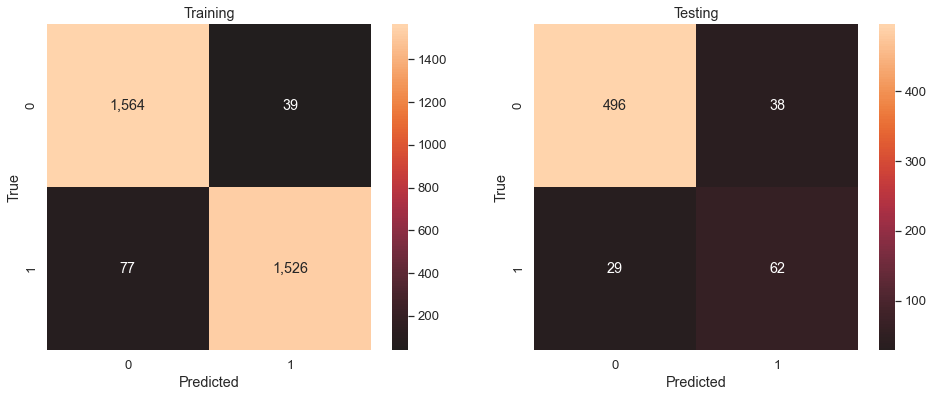

In [14]:
# output confusion matrix
confmat([y_train, y_test], [train_pred, test_pred], ["Training", "Testing"])

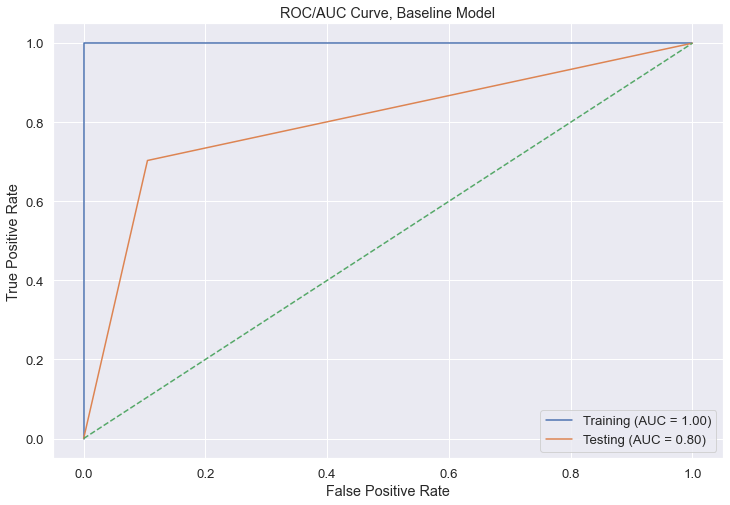

In [15]:
# output roc/ac curve
fig, ax = plt.subplots(figsize=(12, 8))

plot_roc_curve(dt1, X_train, y_train, name="Training", ax=ax)
plot_roc_curve(dt1, X_test, y_test, name="Testing", ax=ax)
line = np.linspace(0, 1)

plt.plot(line, line, "--")

plt.title("ROC/AUC Curve, Baseline Model")
plt.show()

Looking through a parameter space of 7500 possible combinations, We sampled close to 15% of possible models. Of the models tested we found our best model had a depth of 13, and a min sample leaf of 7.
This model resulted in a 89% accuracy, but still had lackluster recall and precision, scoring in the 60-60% range. Our f1 score only marginally increased by .3%.